In [2]:
import sunpy
import sunpy.map
import numpy as np
from math import *
import astropy.units as u
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sunpy.coordinates import frames
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from matplotlib.patches import ConnectionPatch

In [3]:
rsm = fits.open('./data/RSM20240501T064251_0024_HA.fits')
print(rsm[1].data.shape)
hacore = rsm[1].data[68, :, :]
hawing = rsm[1].data[-10, :, :]

(118, 2313, 2304)


In [4]:
# 0.5218" per pixel in bin = 1 mode and 1.0436" per pixel in bin = 2 mode
coord_HIS = SkyCoord(0 * u.arcsec, 0 * u.arcsec, obstime = '2024-05-01 06:42:51', observer = 'earth', \
                     frame = frames.Helioprojective)
headerwing = sunpy.map.make_fitswcs_header(hawing, coord_HIS,
                                       reference_pixel = \
                                       [rsm[1].header['CRPIX1'], rsm[1].header['CRPIX2']] * u.pixel,
                                       scale = [0.5218 * 2, 0.5218 * 2] * u.arcsec / u.pixel,
                                       telescope = 'CHASE', instrument = 'RSM')
headercore = sunpy.map.make_fitswcs_header(hacore, coord_HIS,
                                       reference_pixel = \
                                       [rsm[1].header['CRPIX1'], rsm[1].header['CRPIX2']] * u.pixel,
                                       scale = [0.5218 * 2, 0.5218 * 2] * u.arcsec / u.pixel,
                                       telescope = 'CHASE', instrument = 'RSM')

In [5]:
hawing_map = sunpy.map.Map(hawing, headerwing)
hacore_map = sunpy.map.Map(hacore, headercore)

<Figure size 640x480 with 0 Axes>

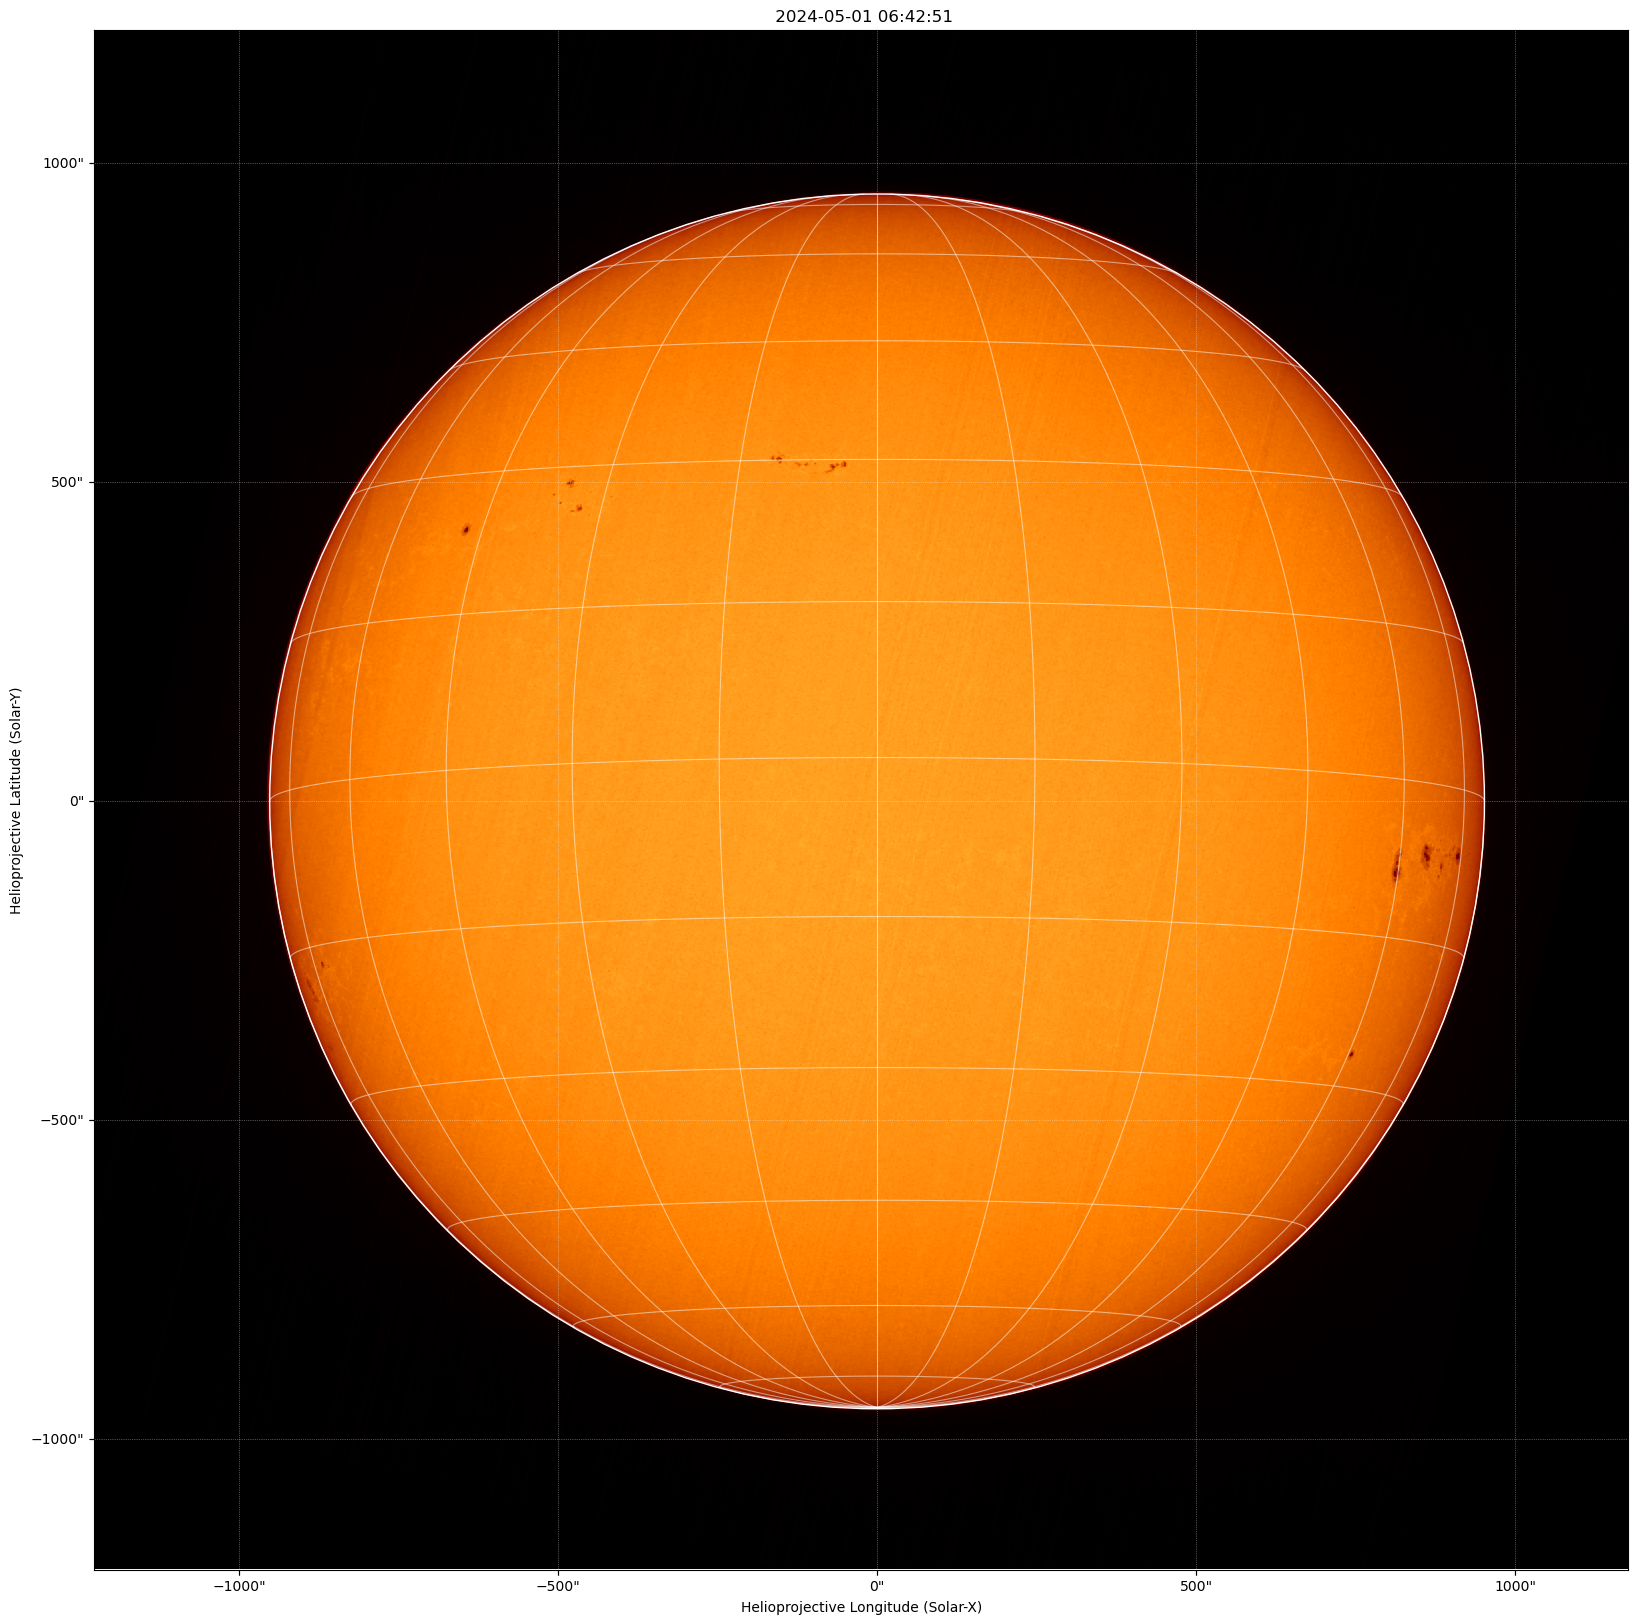

In [6]:
fig = plt.figure()
fig = plt.figure(figsize = (20, 20))
hawing_map.plot(cmap = 'afmhot' , vmin = 0, vmax = 4 * hawing.mean())
hawing_map.draw_grid(color = 'white')
hawing_map.draw_limb()
plt.show()

<Figure size 640x480 with 0 Axes>

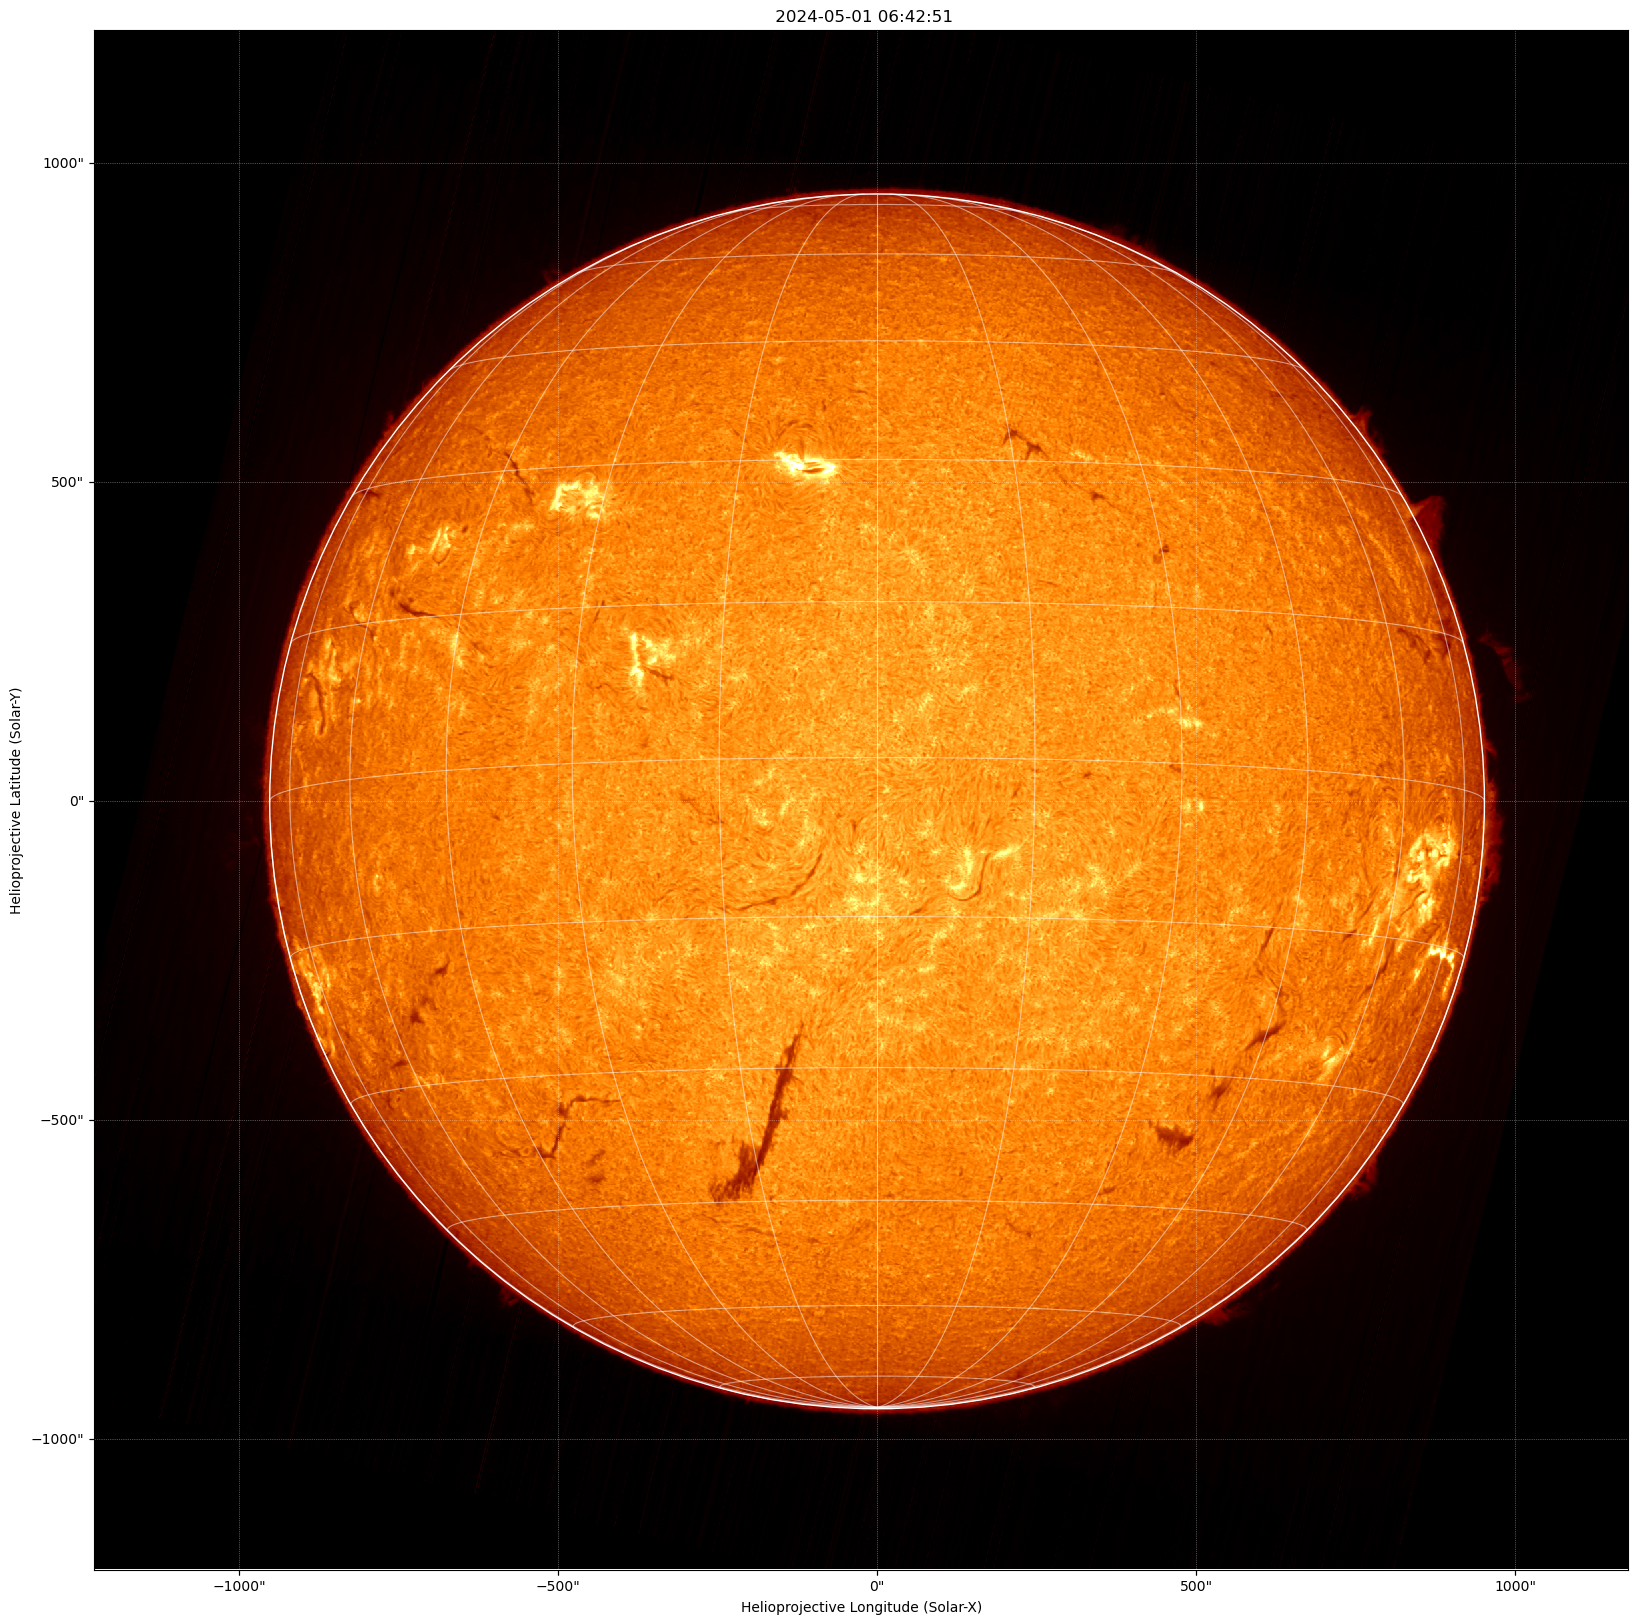

In [7]:
fig = plt.figure()
fig = plt.figure(figsize = (20, 20))
hacore_map.plot(cmap = 'afmhot' , vmin = 0, vmax = 4 * hacore.mean())
hacore_map.draw_grid(color = 'white')
hacore_map.draw_limb()
plt.show()

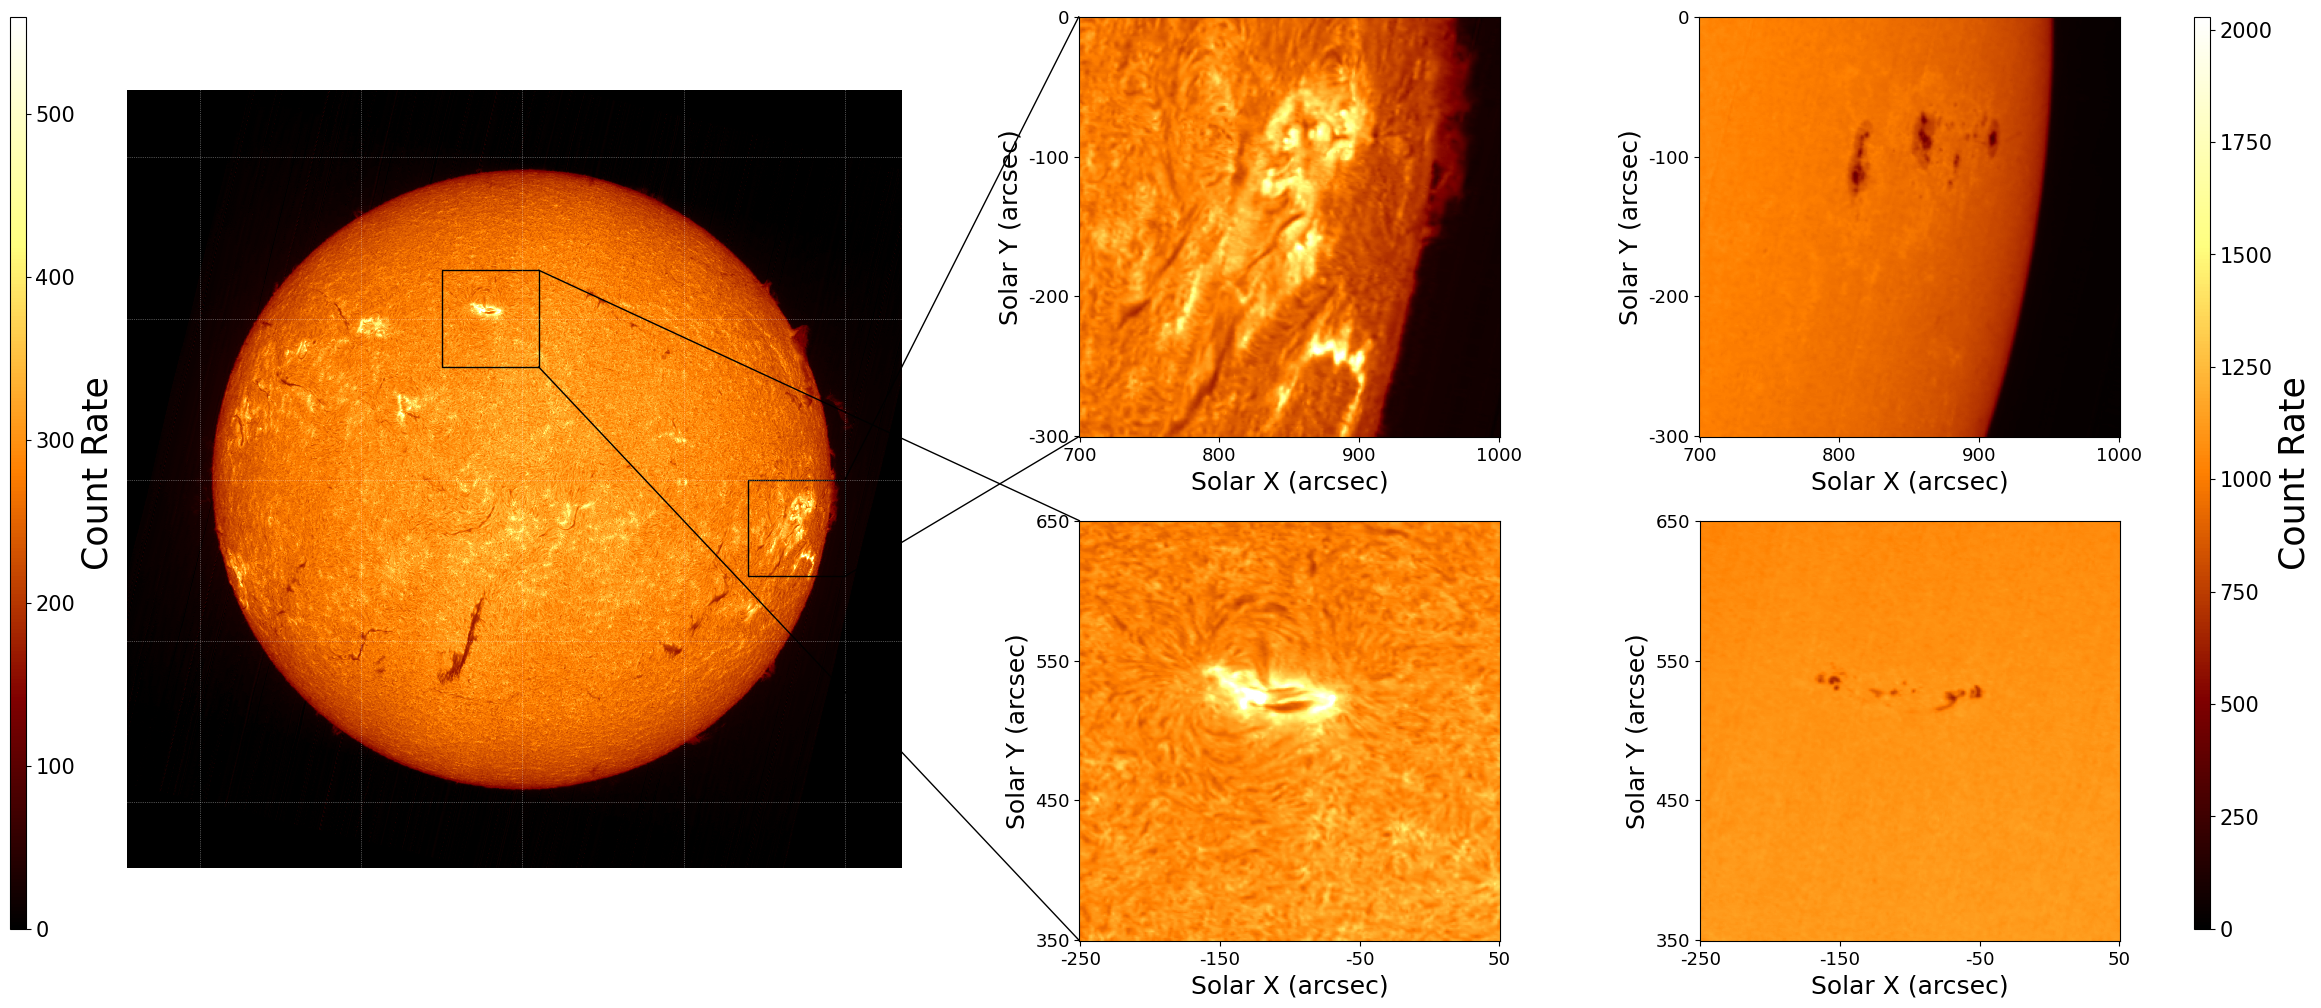

In [8]:
ang_res = 0.5218 * 2

fig = plt.figure(figsize = (26, 12))
gs = gridspec.GridSpec(6, 13, wspace = 0, hspace = 1)


ax1 = fig.add_subplot(gs[0:6, 0:5], projection = hacore_map)
hacore_map.plot(axes = ax1, title = '', cmap = 'afmhot', vmin = 0, vmax = 4 * hacore_map.mean())
plt.grid(False)

left, right, bottom, top = 700, 1000, -300, 0
left_corner = SkyCoord(Tx = left * u.arcsec, Ty = bottom * u.arcsec, frame = hacore_map.coordinate_frame)
right_corner = SkyCoord(Tx = right * u.arcsec, Ty = top * u.arcsec, frame = hacore_map.coordinate_frame)

left2, right2, bottom2, top2 = -250, 50,350, 650
left_corner2 = SkyCoord(Tx = left2 * u.arcsec, Ty = bottom2 * u.arcsec, frame = hacore_map.coordinate_frame)
right_corner2 = SkyCoord(Tx = right2 * u.arcsec, Ty = top2 * u.arcsec, frame = hacore_map.coordinate_frame)

len_arc = (right - left) / 100 + 1
tick_arcsecx = list(np.linspace(left, right, int(len_arc)))
tick_arcsecx = [int(i) for i in tick_arcsecx]
tick_arcsecy = list(np.linspace(bottom, top, int(len_arc)))
tick_arcsecy = [int(i) for i in tick_arcsecy]
tick_pixelx = list(np.linspace(0, (right - left) / ang_res, int(len_arc)))
tick_pixely = list(np.linspace(0, (top - bottom) / ang_res, int(len_arc)))

len_arc2 = (right2 - left2) / 100 + 1
tick_arcsec2x = list(np.linspace(left2, right2, int(len_arc2)))
tick_arcsec2x = [int(i) for i in tick_arcsec2x]
tick_arcsec2y = list(np.linspace(bottom2, top2, int(len_arc2)))
tick_arcsec2y = [int(i) for i in tick_arcsec2y]
tick_pixel2x = list(np.linspace(0, (right2 - left2) / ang_res, int(len_arc2)))
tick_pixel2y = list(np.linspace(0, (top2 - bottom2) / ang_res, int(len_arc2)))

for coord in ax1.coords:
    coord.frame.set_linewidth(0)
    coord.set_ticks_visible(False)
    coord.set_ticklabel_visible(False)

hacore_map.draw_quadrangle(left_corner, top_right = right_corner, edgecolor = 'black', lw = 1)
hacore_map.draw_quadrangle(left_corner2, top_right = right_corner2, edgecolor = 'black', lw = 1)


hacore_map_small = hacore_map.submap(left_corner, top_right = right_corner)
hacore_map_small = hacore_map_small.data
ax2 = fig.add_subplot(gs[0:3, 6:9])
im2 = ax2.imshow(hacore_map_small, origin = 'lower',cmap = 'afmhot', vmin = 0, vmax = 4 * hacore_map.mean())
plt.xlabel('Solar X (arcsec)', fontsize = 18)
plt.ylabel('Solar Y (arcsec)', fontsize = 18)
plt.xticks(ticks = tick_pixelx, labels = tick_arcsecx, fontsize = 13)
plt.yticks(ticks = tick_pixely, labels = tick_arcsecy, fontsize = 13)


wing_small = hawing_map.submap(left_corner, top_right = right_corner)
wing_small = wing_small.data


ax3 = fig.add_subplot(gs[0:3, 10:13])
im3 = ax3.imshow(wing_small, origin = 'lower', cmap = 'afmhot', vmin = 0, vmax = 4 * hawing_map.mean())
plt.xlabel('Solar X (arcsec)', fontsize = 18)
plt.ylabel('Solar Y (arcsec)', fontsize = 18)
plt.xticks(ticks = tick_pixelx, labels = tick_arcsecx, fontsize = 13)
plt.yticks(ticks = tick_pixely, labels = tick_arcsecy, fontsize = 13)


xpix, ypix = hacore_map.world_to_pixel(right_corner)
con1 = ConnectionPatch(
    (0, 1), (xpix.value, ypix.value), 'axes fraction', 'data', axesA = ax2, axesB = ax1,
    arrowstyle = '-', color = 'black', lw = 1
)
xpix, ypix = hacore_map.world_to_pixel(
    SkyCoord(right_corner.Tx, left_corner.Ty, frame = hacore_map.coordinate_frame))
con2 = ConnectionPatch(
    (0, 0), (xpix.value, ypix.value), 'axes fraction', 'data', axesA = ax2, axesB = ax1,
    arrowstyle = '-', color = 'black', lw = 1
)
ax2.add_artist(con1)
ax2.add_artist(con2)

# ax2.contour(hmi_small_dim, levels, origin = 'lower', cmap = 'Accent', linewidths = 2)
# ax3.contour(hmi_small_dim, levels, origin = 'lower', cmap = 'Accent', linewidths = 2)


core_small2 = hacore_map.submap(left_corner2, top_right = right_corner2)
core_small2 = core_small2.data
ax4 = fig.add_subplot(gs[3:6, 6:9])
im4 = ax4.imshow(core_small2, origin = 'lower', cmap = 'afmhot', vmin = 0, vmax = 4 * hacore_map.mean())
plt.xlabel('Solar X (arcsec)', fontsize = 18)
plt.ylabel('Solar Y (arcsec)', fontsize = 18)
plt.xticks(ticks = tick_pixel2x, labels = tick_arcsec2x, fontsize = 13)
plt.yticks(ticks = tick_pixel2y, labels = tick_arcsec2y, fontsize = 13)


wing_small2 = hawing_map.submap(left_corner2, top_right = right_corner2)
wing_small2 = wing_small2.data


ax5 = fig.add_subplot(gs[3:6, 10:13])
im5 = ax5.imshow(wing_small2, origin = 'lower', cmap = 'afmhot', vmin = 0, vmax = 4 * hawing_map.mean())
plt.xlabel('Solar X (arcsec)', fontsize = 18)
plt.ylabel('Solar Y (arcsec)', fontsize = 18)
plt.xticks(ticks = tick_pixel2x, labels = tick_arcsec2x, fontsize = 13)
plt.yticks(ticks = tick_pixel2y, labels = tick_arcsec2y, fontsize = 13)


xpix, ypix = hacore_map.world_to_pixel(right_corner2)
con1 = ConnectionPatch(
    (0, 1), (xpix.value, ypix.value), 'axes fraction', 'data', axesA = ax4, axesB = ax1,
    arrowstyle = '-', color = 'black', lw = 1
)
xpix, ypix = hacore_map.world_to_pixel(
    SkyCoord(right_corner2.Tx, left_corner2.Ty, frame = hacore_map.coordinate_frame))
con2 = ConnectionPatch(
    (0, 0), (xpix.value, ypix.value), 'axes fraction', 'data', axesA = ax4, axesB = ax1,
    arrowstyle = '-', color = 'black', lw = 1
)
ax4.add_artist(con1)
ax4.add_artist(con2)

# ax4.contour(hmi_small2_dim, levels, origin = 'lower', cmap = 'Accent', linewidths = 2)
# ax5.contour(hmi_small2_dim, levels, origin = 'lower', cmap = 'Accent', linewidths = 2)





position = fig.add_axes([0.08, 0.12, 0.006, 0.76]) # 位置[左, 下, 宽, 高]
cb = fig.colorbar(im4, cax = position)
cb.ax.tick_params(labelsize = 15)
cb.set_label('Count Rate', fontsize = 25)

position = fig.add_axes([0.92, 0.12, 0.006, 0.76]) # 位置[左, 下, 宽, 高]
cb = fig.colorbar(im5, cax = position)
cb.ax.tick_params(labelsize = 15)
cb.set_label('Count Rate', fontsize = 25)


plt.show()

<class 'numpy.ndarray'>


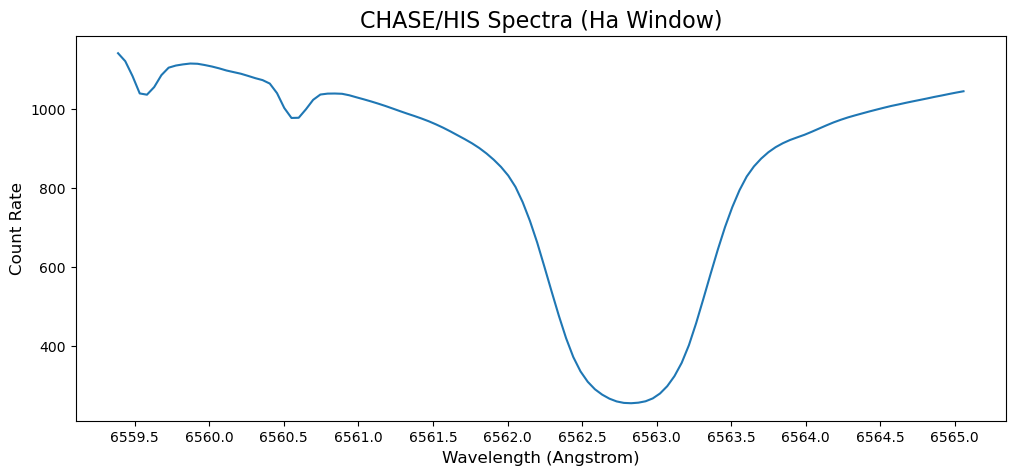

In [48]:
pix_ha = [i for i in range(118)]
wvl_ha = [rsm[1].header['CRVAL3'] + i * rsm[1].header['CDELT3'] for i in range(118)]
f_wvl = interp1d(wvl_ha, pix_ha, 'linear')
wvl_xlabel = [6559.5 + i * 0.5 for i in range(12)]
pix_xlabel = f_wvl(wvl_xlabel)
central_spec = rsm[1].data[:, 1800:1900,950:1050].mean((1, 2))
plt.figure(figsize = (12, 5))
plt.plot(central_spec)
plt.ylabel('Count Rate', size = 12)
plt.xlabel('Wavelength (Angstrom)', size = 12)
plt.title('CHASE/HIS Spectra (Ha Window)', size = 16)
plt.xticks(pix_xlabel, wvl_xlabel)

In [10]:
def gaussian(lx, *param):
    return param[0] * e ** (-(lx - param[1]) ** 2 / param[2] ** 2) + param[3]

def gaussian2(lx, *param):
    return param[0] * e ** (-(lx - param[1]) ** 2 / param[2] ** 2) + \
           param[3] * e ** (-(lx - param[4]) ** 2 / param[5] ** 2) + param[6]

def gaussfit(lx, ly, draw = 0, p0 = [1, 1, 1, 1], component = 1):
    if component == 1:
        para, pcov = curve_fit(gaussian, lx, ly, p0, method = 'lm')
        # pcov is covariance matrix
        if draw != 0:
            fitted = [para[0] * np.e ** (-(xi - para[1]) ** 2 / para[2] ** 2) + para[3] for xi in lx]
    if component == 2:
        para, pcov = curve_fit(gaussian2, lx, ly, p0, method = 'lm')
        # pcov is covariance matrix
        if draw != 0:
            fitted = [para[0] * np.e ** (-(xi - para[1]) ** 2 / para[2] ** 2) + \
                      para[3] * np.e ** (-(xi - para[4]) ** 2 / para[5] ** 2) + para[6] for xi in lx]
    if draw != 0:
        plt.subplot(211)
        plt.plot(lx, ly, 'b+:', label = 'data')
        plt.plot(lx, fitted, 'ro:', label = 'fit')
        plt.grid()
        plt.legend()
        plt.subplot(212)
        l0 = []
        lr = []
        for i in range(len(lx)):
            l0.append(0)
            lr.append(fitted[i] - ly[i])
        plt.plot(lx, l0, 'blue', linewidth = 2)
        plt.scatter(lx, lr, color = 'red')
        plt.grid()
    return(para, pcov)

[-8.80650923e+02  6.56280999e+03  7.60326988e-01  1.10198449e+03]


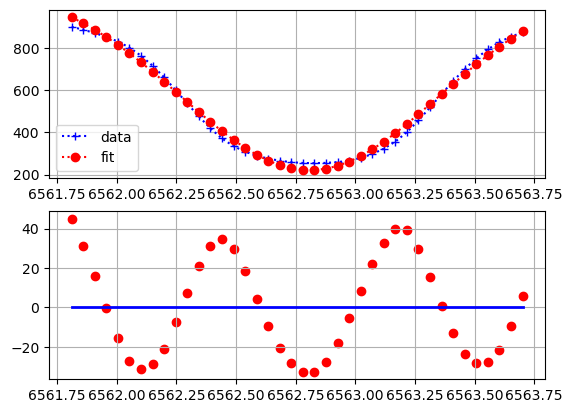

In [11]:
para, pcov = gaussfit(wvl_ha[50:90], central_spec[50:90], draw = 1, \
         p0 = [central_spec[68] - central_spec[-1], 6562.82, 0.5, central_spec[-20:].mean()])
print(para)

In [12]:
def bi_sectrix(intensity, spectra, linecenter):
    
    for i in range(len(spectra)): # towards red side
        ia = spectra[linecenter + i] - intensity
        ib = spectra[linecenter + i + 1] - intensity
        if ia * ib <= 0:
            break
    
    for j in range(len(spectra)): # towards blue side
        ja = spectra[linecenter - j] - intensity
        jb = spectra[linecenter - j - 1] - intensity
        if ja * jb <= 0:
            break
    
    right_side = linecenter + i + abs(ia) / (abs(ib) + abs(ia))
    left_side = linecenter - j - abs(ja) / (abs(jb) + abs(ja))
    
    return [left_side, right_side], right_side - left_side, (left_side + right_side) / 2

0.35 6562.818541467577
0.44999999999999996 6562.813116613933
0.55 6562.812377195421
0.65 6562.811829077595
0.75 6562.811866590556


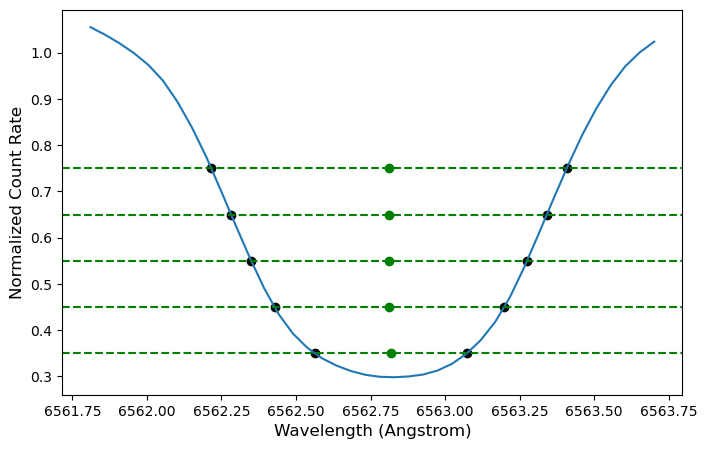

In [13]:
wvlstep = rsm[1].header['CDELT3']
wvl0 = rsm[1].header['CRVAL3']

central_spec_norm = central_spec / sum(central_spec) * len(central_spec)

plt.figure(figsize = (8, 5))
plt.plot(wvl_ha[50:90], central_spec_norm[50:90])
plt.xlabel('Wavelength (Angstrom)', size = 12)
plt.ylabel('Normalized Count Rate', size = 12)
for i in range(5):
    left_right, fw, bisectrix = bi_sectrix(0.35 + i * 0.1, central_spec_norm, 70)
    print(0.35 + i * 0.1, bisectrix * wvlstep + wvl0)
    plt.axhline(0.35 + i * 0.1, color = 'green', linestyle = 'dashed')
    plt.scatter([left_right[0] * wvlstep + wvl0, left_right[1] * wvlstep + wvl0], \
                [0.35 + i * 0.1, 0.35 + i * 0.1], color = 'black')
    plt.scatter(bisectrix * wvlstep + wvl0, 0.35 + i * 0.1, color = 'green')

In [14]:
def pearson(vector1, vector2):
    # should have len(vector1) == len(vector2)
    n = len(vector1)

    sum1 = sum(vector1)
    sum2 = sum(vector2)

    sum1_pow = sum([pow(v, 2.0) for v in vector1])
    sum2_pow = sum([pow(v, 2.0) for v in vector2])

    p_sum = sum([vector1[i] * vector2[i] for i in range(n)])

    num = p_sum - (sum1 * sum2 / n)
    den = sqrt((sum1_pow - pow(sum1, 2) / n) * (sum2_pow - pow(sum2, 2) / n))
    if den == 0:
        return 0.0
    return num / den

def polyfit_p(x, y, n, draw = 0):
    # return para: a0, a1, a2, ..., an for y = a0 + a1 * x + a2 * x ** 2 + ... + an * x ** n
    pfpara, pfcov = np.polyfit(x, y, n, cov = True)

    if draw != 0:
        plt.subplot(211)
        lx2 = x
        ly2 = []
        for i in range(len(lx2)):
            y2 = 0
            for j in range(len(pfpara)):
                y2 += pfpara[-j - 1] * lx2[i] ** j
            ly2.append(y2)
        plt.plot(x, y, 'ro', lx2, ly2, 'b', linewidth = 2)
        plt.grid()

        plt.subplot(212)
        l0 = []
        lr = []
        for i in range(len(lx2)):
            l0.append(0)
            lr.append(y[i] - ly2[i])
        plt.plot(x, l0, 'black', linewidth = 2)
        plt.scatter(x, lr, color = 'red')
        plt.grid()

    para = list(pfpara)
    para = para[::-1]

    mat_cov = []
    for i in range(len(pfcov)):
        mat_cov.append(pfcov[-i - 1][-i - 1])

    return para, mat_cov

In [58]:
def get_dplv(i,j):
    is_all_zero = np.all(rsm[1].data[68,i,j] == 0)
    if is_all_zero == True :
        return 0
    ij_spec = rsm[1].data[50:90, i, j]

    dict_c = {}
    for lag in range(-10, 11):
        ha_profilel = central_spec[lag + 50:lag + 90] # move the ha profile, but keep the length
        pr = pearson(ha_profilel, ij_spec)
        dict_c[-lag] = pr

    # use cubic fit to get the lag of the largest pearson correlation
    lag_max = max(dict_c, key = lambda x:dict_c[x])
    l_lag = [lag_max - k for k in range(-2, 3)]

    l_pr = [dict_c[k] for k in l_lag]

    para_cf, pcov_cf = polyfit_p(l_lag, l_pr, 3)

    a0, a1, a2, a3 = para_cf[0], para_cf[1], para_cf[2], para_cf[3] # in format of a0 + a1 * x  + a2 * x ** 2 + a3 * x ** 3
    s0, s1, s2, s3 = pcov_cf[0], pcov_cf[1], pcov_cf[2], pcov_cf[3]

    dcf01 = (-2 * a2 + sqrt((2 * a2) ** 2 - 12 * a1 * a3)) / (6 * a3)
    dcf02 = (-2 * a2 - sqrt((2 * a2) ** 2 - 12 * a1 * a3)) / (6 * a3)

    d2cf1 = 6 * a3 * dcf01 + 2 * a2
    d2cf2 = 6 * a3 * dcf02 + 2 * a2

    covcf1_2 = s1 * (1 / ((2 * a2) ** 2 - 12 * a1 * a3)) + \
    s2 * (-1 / (3 * a3) + 2 * a2 / (3 * a3 * sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2 + \
    s3 * (a2 / (3 * a3 ** 2) - (1 / (6 * a3 ** 2)) * (6 * a1 * a3 / sqrt((2 * a2) ** 2 - 12 * a1 * a3) + \
    sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2
    covcf2_2 = s1 * (1 / ((2 * a2) ** 2 - 12 * a1 * a3)) + \
    s2 * (-1 / (3 * a3) - 2 * a2 / (3 * a3 * sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2 + \
    s3 * (a2 / (3 * a3 ** 2) + (1 / (6 * a3 ** 2)) * (6 * a1 * a3 / sqrt((2 * a2) ** 2 - 12 * a1 * a3) + \
    sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2

    if d2cf1 < 0:
        cal_shift_cf = dcf01
        cal_stddev_cf = sqrt(covcf1_2)
    else:
        cal_shift_cf = dcf02
        cal_stddev_cf = sqrt(covcf2_2)
     
    return cal_shift_cf * 1.1068

get_dplv(1000,1000)

-0.0977287098861199

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#创造一个从红到蓝的颜色条
# 定义颜色段的起始和结束颜色
red = (1, 0, 0, 1)  # 红色，不透明
blue = (0, 0, 1, 1)  # 蓝色，不透明

# 创建颜色列表，这里只定义了两个颜色段：从红色到蓝色
colors = [red, blue]

# 使用分段函数创建colormap
rtb_cmap = mcolors.LinearSegmentedColormap.from_list('red_to_blue', colors)

# 创建一个布尔掩码，找出所有非零元素
nonzero_mask = rsm[1].data[68, :, :] != 0

# 使用 np.where 找到非零元素的索引
nonzero_rows, nonzero_cols = np.where(nonzero_mask)

# 如果你想要将这些坐标保存到一个列表中
nonzero_coordinates = list(zip(nonzero_rows, nonzero_cols))

# 创建一个空矩阵
rows, cols = 3000, 3000 
matrix=np.zeros((rows,cols))

#输入
for k in range (0,np.size(nonzero_coordinates)-1):
    i=nonzero_coordinates[k][0]
    j=nonzero_coordinates[k][1]
    matrix[i,j]=get_dplv(i,j) 

#matrix=np.random.randn(rows, cols)

# 将矩阵的数值归一化到-1和1之间
normalized_matrix = (matrix - np.mean(matrix)) / (matrix.max() - matrix.min())

# 使用imshow函数绘制图像
plt.imshow(normalized_matrix, cmap=rtb_cmap)
plt.xticks([])
plt.yticks([])

# 显示颜色条
plt.colorbar(ticks=[-1,0,1])

# 显示图像
plt.show()

KeyError: 12

In [20]:
print(rsm[1].data.shape[2])

2304


非零元素的行索引范围: 0 到 2312
非零元素的列索引范围: 0 到 2303


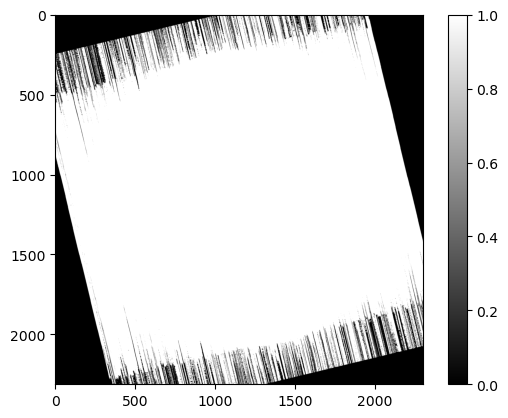

5329152


In [29]:
nonzero_mask = rsm[1].data[68,:,:] != 0
nonzero_indices = np.where(nonzero_mask)
min_row, max_row = nonzero_indices[0].min(), nonzero_indices[0].max()
min_col, max_col = nonzero_indices[1].min(), nonzero_indices[1].max()
print(f"非零元素的行索引范围: {min_row} 到 {max_row}")
print(f"非零元素的列索引范围: {min_col} 到 {max_col}")
plt.imshow(nonzero_mask, cmap='gray')  # 使用灰度色图显示非零值
plt.colorbar()  # 显示颜色条
plt.show()
print(np.size(nonzero_mask))

In [38]:
# 假设 rsm[1].data[68, :, :] 是你的二维数组
# 创建一个布尔掩码，找出所有非零元素
nonzero_mask = rsm[1].data[68, :, :] != 0

# 使用 np.where 找到非零元素的索引
nonzero_rows, nonzero_cols = np.where(nonzero_mask)

# 如果你想要将这些坐标保存到一个列表中
nonzero_coordinates = list(zip(nonzero_rows, nonzero_cols))

# 获取非零元素的行索引范围（x坐标的最大值和最小值）
min_row = np.min(nonzero_rows)
max_row = np.max(nonzero_rows)

# 获取非零元素的列索引范围（y坐标的最大值和最小值）
min_col = np.min(nonzero_cols)
max_col = np.max(nonzero_cols)

# 打印结果
print(f"行坐标（x坐标）的最小值和最大值: {min_row} 和 {max_row}")
print(f"列坐标（y坐标）的最小值和最大值: {min_col} 和 {max_col}")

print(np.size(nonzero_coordinates))

行坐标（x坐标）的最小值和最大值: 0 和 2312
列坐标（y坐标）的最小值和最大值: 0 和 2303
8616662



In [60]:
ij_spec = rsm[1].data[50:90, 0, 1000]

dict_c = {}
for lag in range(-10, 11):
    ha_profilel = central_spec[lag + 50:lag + 90] # move the ha profile, but keep the length
    pr = pearson(ha_profilel, ij_spec)
    dict_c[-lag] = pr

# use cubic fit to get the lag of the largest pearson correlation
lag_max = max(dict_c, key = lambda x:dict_c[x])
l_lag = [lag_max - k for k in range(-2, 3)]

l_pr = [dict_c[k] for k in l_lag]

para_cf, pcov_cf = polyfit_p(l_lag, l_pr, 3)

a0, a1, a2, a3 = para_cf[0], para_cf[1], para_cf[2], para_cf[3] # in format of a0 + a1 * x  + a2 * x ** 2 + a3 * x ** 3
s0, s1, s2, s3 = pcov_cf[0], pcov_cf[1], pcov_cf[2], pcov_cf[3]

dcf01 = (-2 * a2 + sqrt((2 * a2) ** 2 - 12 * a1 * a3)) / (6 * a3)
dcf02 = (-2 * a2 - sqrt((2 * a2) ** 2 - 12 * a1 * a3)) / (6 * a3)

d2cf1 = 6 * a3 * dcf01 + 2 * a2
d2cf2 = 6 * a3 * dcf02 + 2 * a2

covcf1_2 = s1 * (1 / ((2 * a2) ** 2 - 12 * a1 * a3)) + \
s2 * (-1 / (3 * a3) + 2 * a2 / (3 * a3 * sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2 + \
s3 * (a2 / (3 * a3 ** 2) - (1 / (6 * a3 ** 2)) * (6 * a1 * a3 / sqrt((2 * a2) ** 2 - 12 * a1 * a3) + \
sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2
covcf2_2 = s1 * (1 / ((2 * a2) ** 2 - 12 * a1 * a3)) + \
s2 * (-1 / (3 * a3) - 2 * a2 / (3 * a3 * sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2 + \
s3 * (a2 / (3 * a3 ** 2) + (1 / (6 * a3 ** 2)) * (6 * a1 * a3 / sqrt((2 * a2) ** 2 - 12 * a1 * a3) + \
sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2

if d2cf1 < 0:
    cal_shift_cf = dcf01
    cal_stddev_cf = sqrt(covcf1_2)
else:
    cal_shift_cf = dcf02
    cal_stddev_cf = sqrt(covcf2_2)

print(cal_shift_cf * 1.1068, 'km/s')
plt.figure(figsize = (12, 5))
plt.plot(wvl_ha[50:90], central_spec[50:90], color = 'black', label = 'Zero doppler velocity profile')
plt.plot(wvl_ha[50:90], ij_spec, color = 'red', label = 'Profile at a specific point')
plt.legend()

KeyError: 12